##### Mediapipe 即時合成搞笑橘子臉
這篇教學會使用「Mediapipe 人臉偵測」搭配「邊緣羽化效果」文章，透過人臉辨識擷取出眼睛和嘴巴，\
再將眼睛與嘴巴合成到橘子圖片上，做出搞笑橘子臉的效果。

* 參考：\
[Mediapipe 人臉偵測](https://steam.oxxostudio.tw/category/python/ai/ai-mediapipe-face-detection.html)\
[邊緣羽化效果](https://steam.oxxostudio.tw/category/python/ai/opencv-feather-edge.html)

因為程式中的 OpenCV 會需要使用鏡頭或 GPU，所以請使用本機環境或使用 Anaconda Jupyter 進行實作，\
並安裝 OpenCV 函式庫 ( 參考：[OpenCV 函式庫](https://steam.oxxostudio.tw/category/python/ai/opencv.html) )。

##### 即時合成搞笑橘子臉 
因為整體程式碼較多，因此將詳細說明寫在程式碼的註解內，程式碼的重點如下：
* 沿用「[Mediapipe 人臉偵測](https://steam.oxxostudio.tw/category/python/ai/ai-mediapipe-face-detection.html)」文章的範例程式。
* 參考「[邊緣羽化效果](https://steam.oxxostudio.tw/category/python/ai/opencv-feather-edge.html)」文章，在指定位置建立遮罩 ( 指定位置需要和擷取出來的眼睛嘴巴對應 )。
* 透過座標和人臉的大小，抓取出眼睛和嘴巴範圍內的影像。
* 將眼睛嘴巴組合成新圖像，套用邊緣羽化的遮罩，和橘子圖片背景合成 ( [圖片下載](https://steam.oxxostudio.tw/download/python/ai-orange-face.jpg) )。

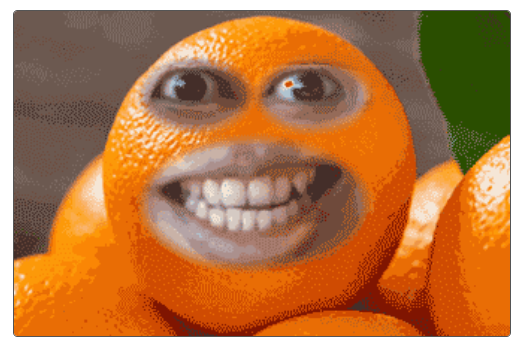

In [ ]:
import cv2
import mediapipe as mp
import numpy as np

cap = cv2.VideoCapture(0)  # 讀取攝影鏡頭
mp_face_detection = mp.solutions.face_detection  # 使用人臉偵測方法

h, w = 360, 640  # 輸出時的影像長寬
mask = np.zeros((h, w, 3), dtype='uint8')  # 建立遮罩

# 繪製左眼的橢圓形遮罩
cv2.ellipse(mask, (260, 100), (55, 35), 0, 0, 360, (255, 255, 255), -1)
# 繪製右眼的橢圓形遮罩
cv2.ellipse(mask, (380, 100), (55, 35), 0, 0, 360, (255, 255, 255), -1)
# 繪製嘴巴的橢圓形遮罩
cv2.ellipse(mask, (320, 212), (115, 66), 0, 0, 360, (255, 255, 255), -1)

mask = cv2.GaussianBlur(mask, (35, 35), 0)  # 將遮罩進行高斯模糊
mask = mask / 255  # 轉換成比例

orange = cv2.imread(r'Img/29/orange.jpg')  # 讀取橘子圖片背景

# 人臉偵測模組啟用成功後，執行相關內容
with mp_face_detection.FaceDetection(
    model_selection=0,  # 模型選擇，0 為輕量級模型，1 為全量模型
    min_detection_confidence=0.5  # 最小偵測信心值，範圍為 [0.0, 1.0]
) as face_detection:

    if not cap.isOpened():
        print("Cannot open camera")  # 無法開啟攝影機時，印出錯誤訊息並退出
        exit()

    out = np.zeros((h, w, 3), dtype='uint8')  # 初始化 out 變數

    while True:
        ret, img = cap.read()  # 讀取攝影機畫面
        if not ret:
            print("Cannot receive frame")  # 無法接收影像時，印出錯誤訊息並跳出迴圈
            break

        img = cv2.resize(img, (w, h))  # 縮小尺寸加快速度
        img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 轉換成 RGB 才能夠在 mediapipe 中使用
        results = face_detection.process(img2)  # 讀取人臉偵測資訊

        if results.detections:
            for detection in results.detections:
                s = detection.location_data.relative_bounding_box  # 取得人臉尺寸
                eye_w = int(s.width * w * 0.24 / 2)  # 計算眼睛寬度 ( 除以 2 計算座標使用 )
                eye_h = int(s.width * w * 0.16 / 2)  # 計算眼睛高度 ( 除以 2 計算座標使用 )
                mouth_w = int(s.width * w * 0.5 / 2)  # 計算嘴巴寬度 ( 除以 2 計算座標使用 )
                mouth_h = int(s.width * w * 0.3 / 2)  # 計算嘴巴高度 ( 除以 2 計算座標使用 )

                eye_r = detection.location_data.relative_keypoints[0]  # 左眼中心點座標
                eye_l = detection.location_data.relative_keypoints[1]  # 右眼中心點座標
                mouth = detection.location_data.relative_keypoints[3]  # 嘴巴中心點座標

                rcx, rcy = int(eye_r.x * w), int(eye_r.y * h)  # 計算左眼真正的座標
                lcx, lcy = int(eye_l.x * w), int(eye_l.y * h)  # 計算右眼真正的座標
                mx, my = int(mouth.x * w), int(mouth.y * h)  # 計算嘴巴真正的座標

                # 取出右眼的區域
                eye_r_img = img[rcy - eye_h:rcy + eye_h, rcx - eye_w:rcx + eye_w]
                eye_r_img = cv2.resize(eye_r_img, (120, 80))  # 改變尺寸為 120x80

                # 取出左眼的區域
                eye_l_img = img[lcy - eye_h:lcy + eye_h, lcx - eye_w:lcx + eye_w]
                eye_l_img = cv2.resize(eye_l_img, (120, 80))  # 改變尺寸為 120x80

                # 取出嘴巴的區域
                mouth_img = img[my - mouth_h:my + mouth_h, mx - mouth_w:mx + mouth_w]
                mouth_img = cv2.resize(mouth_img, (240, 144))  # 改變尺寸為 240x144

                face = np.zeros((h, w, 3), dtype='uint8')  # 建立空白全黑畫布
                bg = orange.copy()  # 複製 orange 圖片當作背景

                # 貼上左眼
                face[60:140, 200:320] = eye_l_img
                # 貼上右眼
                face[60:140, 320:440] = eye_r_img
                # 貼上嘴巴
                face[140:284, 200:440] = mouth_img

                face = face + 30  # 增加亮度
                face = face / 255  # 轉換成比例
                bg = bg / 255  # 轉換成比例

                # 根據比例混合
                out = bg * (1 - mask) + face * mask
                out = (out * 255).astype('uint8')  # 轉換成數字

        cv2.imshow('oxxostudio', out)  # 顯示影像
        if cv2.waitKey(5) == ord('q'):
            break  # 按下 q 鍵停止

cap.release()  # 釋放攝影機資源
cv2.destroyAllWindows()  # 關閉所有 OpenCV 視窗